In [69]:
import pandas as pd 
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 100000

from sklearn.model_selection import train_test_split
import lightgbm as lgb
import matplotlib.cm as cmx

import warnings
from warnings import simplefilter
warnings.filterwarnings("ignore")
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)


df_train = pd.read_csv('optiver-trading-at-the-close/train.csv')
df_train.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


### Data Cleaning

In [70]:

#df_train = df_train.drop(["far_price", "near_price", "row_id", "time_id",'date_id'], axis=1)
df_train = df_train.dropna()
df_train.index = list(range(len(df_train)))

### Feature Engineering

In [71]:
# Test out possible combinations of existing combinations of factors

#Test out features regarding price
#Change in reference price; Possible momentum target
df_train['d_wap'] = df_train.groupby(['stock_id','date_id'])[['wap']].apply(lambda grp: grp.diff().fillna(0))  

#Proxy for liquidity; smaller spread higher liq
df_train['bid_ask_spr'] = df_train['ask_price']-df_train['bid_price']

#Volatility
df_train['wap_vol'] = df_train.groupby(['stock_id','date_id'])[['wap']].apply(lambda grp: grp.expanding(10).std().fillna(0))


#Price Zscore
df_train['wap_zscore'] = df_train.groupby(['stock_id','date_id'])[['wap']].apply(lambda grp: (grp-grp.rolling(10).mean())/grp.rolling(10).std()).fillna(0)
#wap and ref_price differential
df_train['ref_px_m_wap'] = df_train['wap']-df_train['reference_price']


#Features for volume
df_train['px_pressure'] = df_train['bid_size']-df_train['ask_size']
#Auction Pressure
df_train['auction_pressure'] = df_train['imbalance_size']*df_train['imbalance_buy_sell_flag'] - df_train['px_pressure']
df_train['auction_pressure2'] = df_train['imbalance_size']*df_train['imbalance_buy_sell_flag']



### Data Exploration

In [72]:
s = df_train[df_train['stock_id']==0]

In [73]:
s.columns

Index(['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'target', 'time_id', 'row_id', 'd_wap',
       'bid_ask_spr', 'wap_vol', 'wap_zscore', 'ref_px_m_wap', 'px_pressure',
       'auction_pressure', 'auction_pressure2'],
      dtype='object')

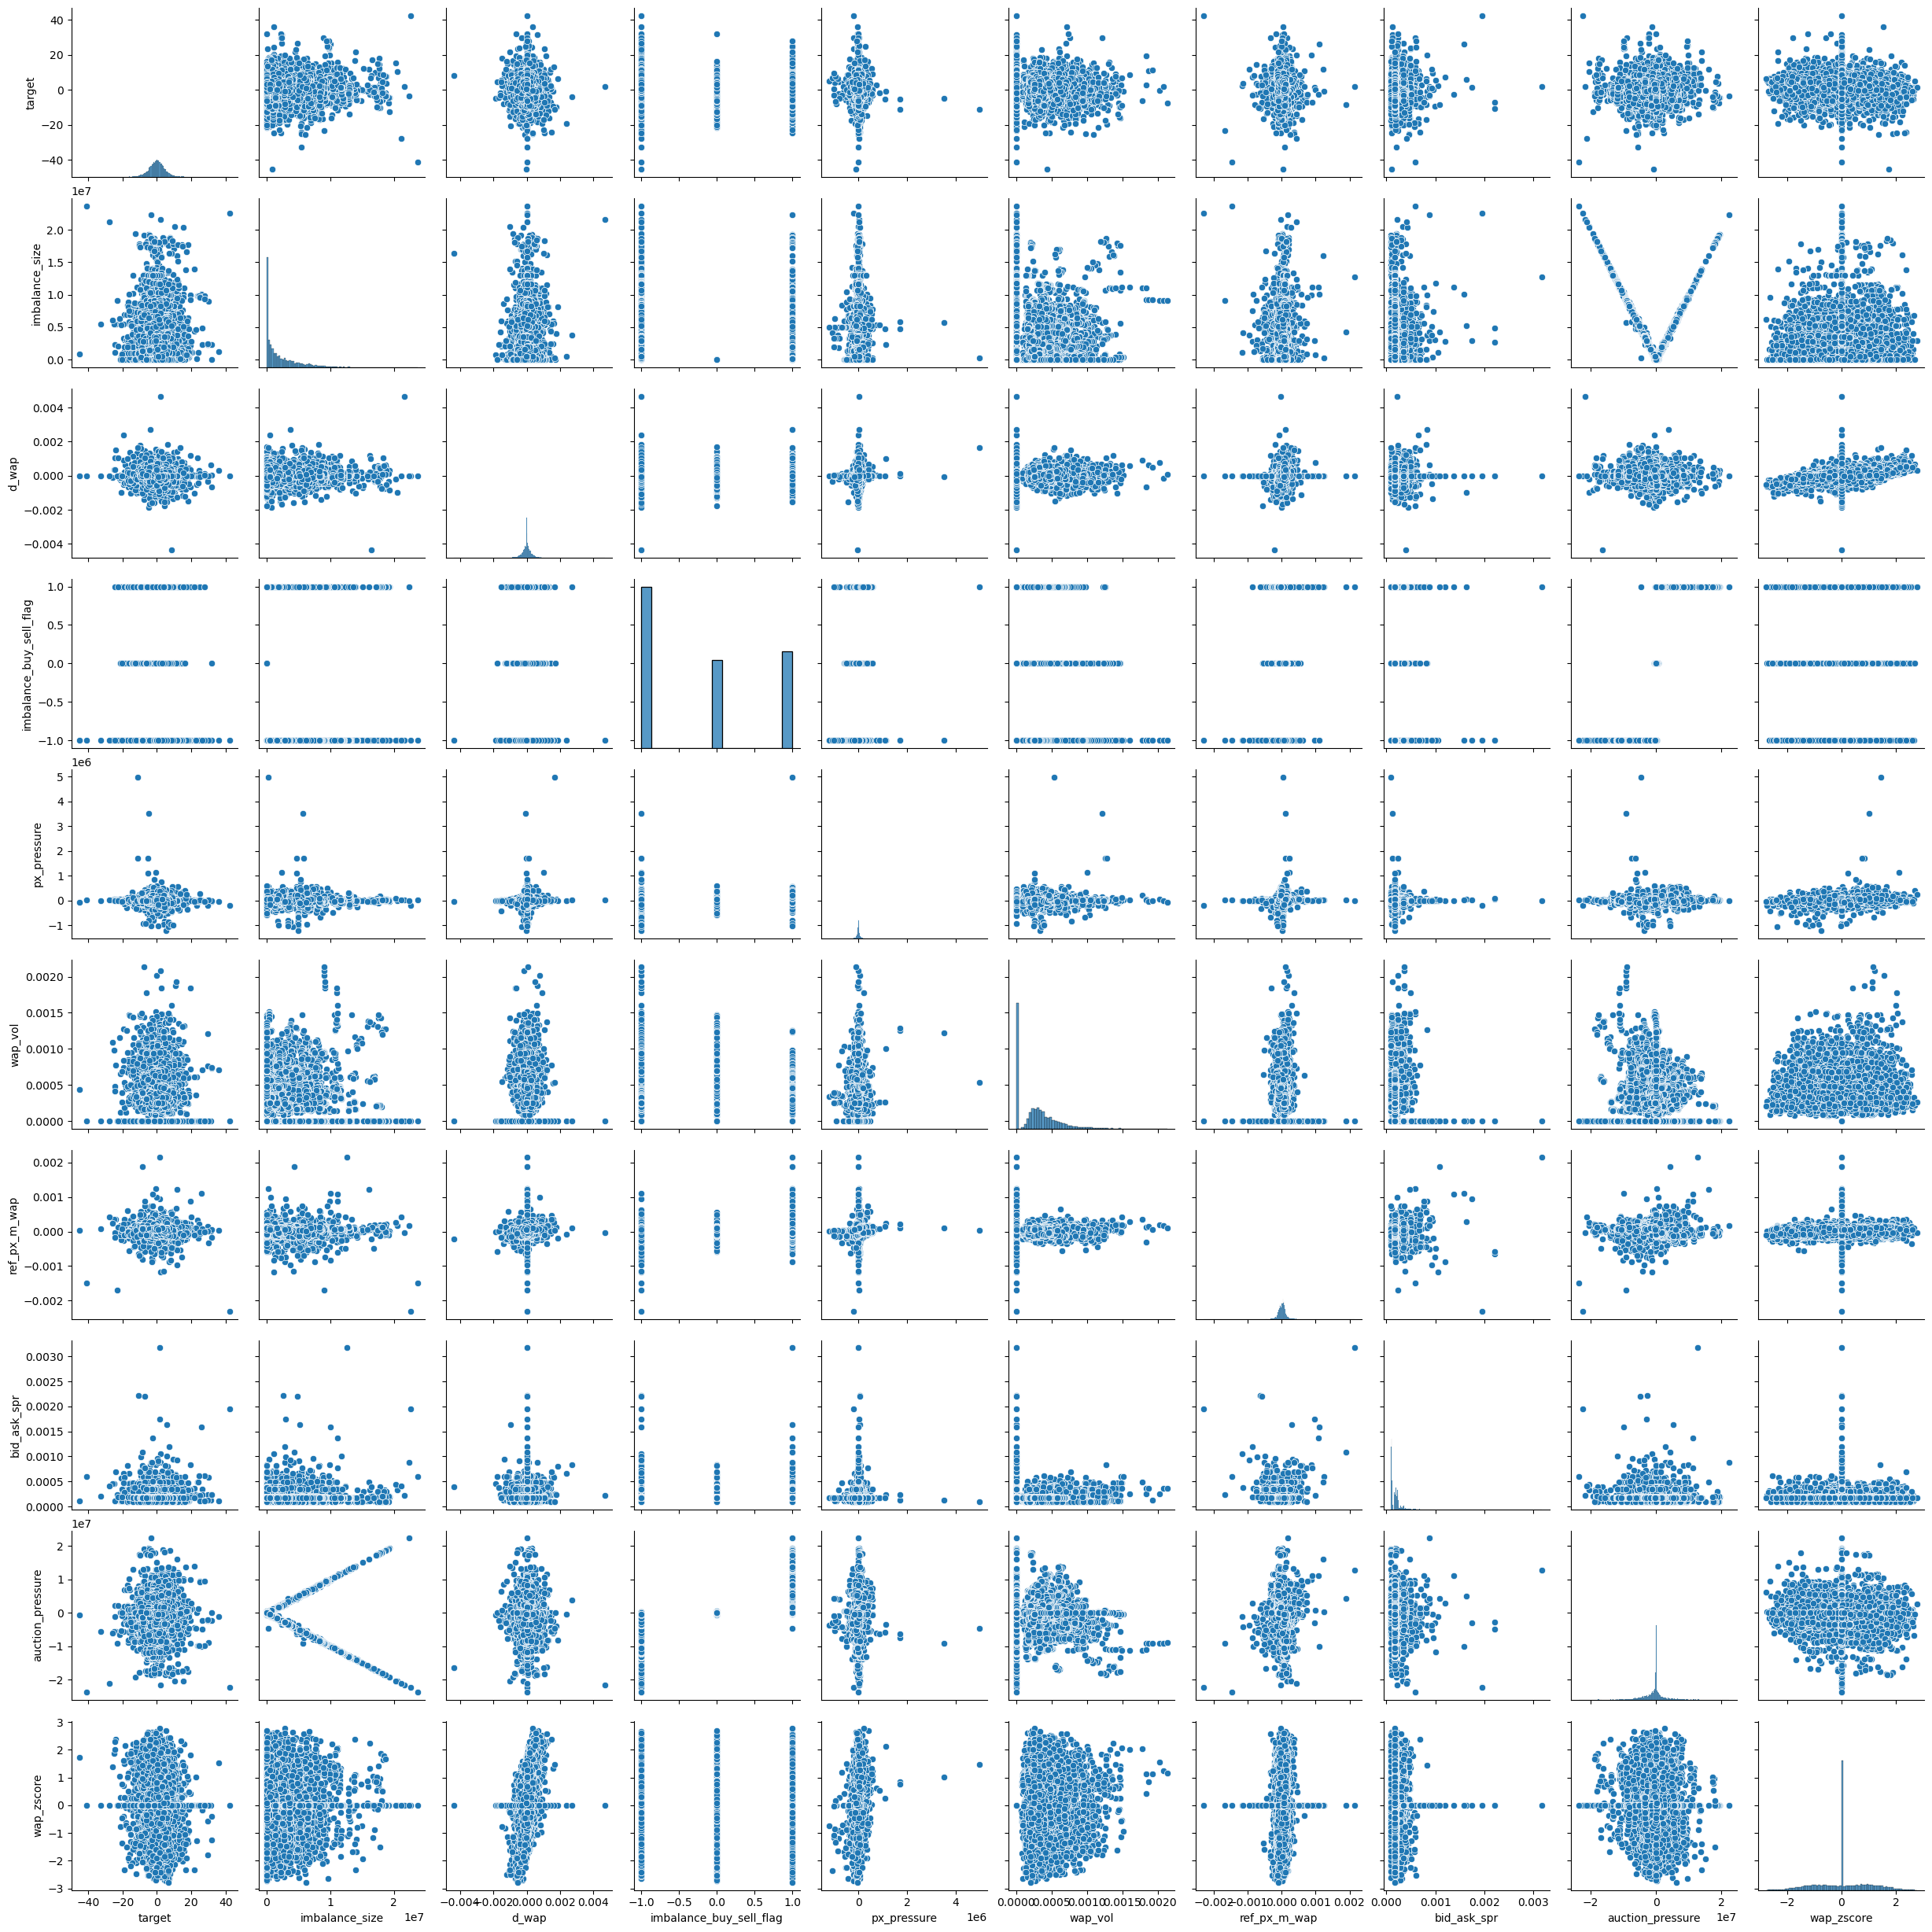

In [74]:
import seaborn as sns

sns.pairplot(s[['target','imbalance_size','d_wap','imbalance_buy_sell_flag','px_pressure','wap_vol','ref_px_m_wap','bid_ask_spr','auction_pressure','wap_zscore']])

# Feature Engineering


Text(0.5, 1.0, 'Correlation Chart (Features vs Target)')

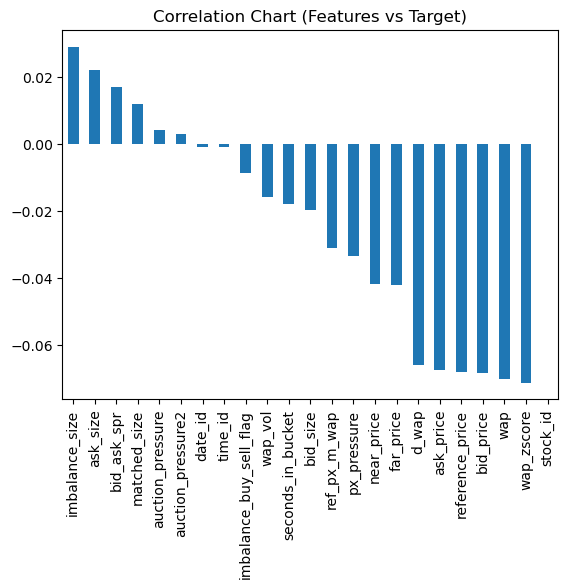

In [75]:
s.corr()['target'].sort_values(ascending=False)[1:].plot(kind = 'bar',label = 'Correlation Chart')
plt.title('Correlation Chart (Features vs Target)')

# We find imbalance size, ask size, bid ask spread, matched size and acution pressure to have positive correlation (although very small)
# We find the wap z_score, bid_price, reference_price, and d_wap to have negative correlation with the target variable

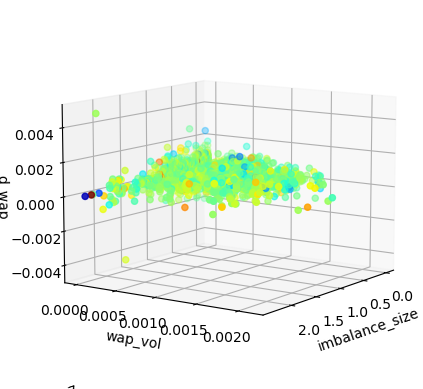

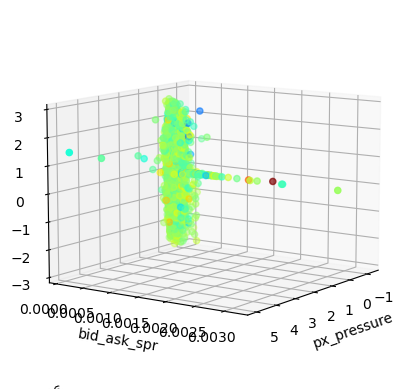

In [76]:
# importing mplot3d toolkits, numpy and matplotlib
# syntax for 3-D projection
xs = ['imbalance_size','px_pressure']
ys = ['wap_vol','bid_ask_spr']
zs = ['d_wap','wap_zscore']
w = 'target'

for x,y,z in zip(xs,ys,zs):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    

    
    # defining all 3 axis
    z_vals = s[z].values
    x_vals = s[x].values
    y_vals = s[y].values
    w_vals = s[w].values
    
    cm = plt.get_cmap('jet')
    cNorm = mpl.colors.Normalize(vmin=min(w_vals), vmax=max(w_vals))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    # plotting
    ax.scatter(x_vals, y_vals, z_vals, marker = 'o',c=scalarMap.to_rgba(w_vals))
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_zlabel(z)
    ax.view_init(10, 35)
    plt.show()

In [88]:
x = ['imbalance_size','ask_size','bid_ask_spr','px_pressure','d_wap','wap_zscore','wap']

In [144]:
x = ['imbalance_size','ask_size','bid_ask_spr','auction_pressure','d_wap','wap_zscore','wap']

In [145]:


y_train = df_train["target"]
x_train = df_train[x]

X_tr = x_train[:-3*55*200]
X_va = x_train[-3*55*200:]
y_tr = y_train[:-3*55*200]
y_va = y_train[-3*55*200:]

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mae',
    'n_estimators': 10000,
    'num_leaves':31,
    'reg_lambda':0.5
}

model = lgb.LGBMRegressor(**params)
model.fit(
    X_tr,
    y_tr,
    eval_set=[(X_tr, y_tr), (X_va, y_va)],
    callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=True), lgb.log_evaluation(10)]
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 2310638, number of used features: 7
[LightGBM] [Info] Start training from score -0.038372
Training until validation scores don't improve for 200 rounds
[10]	training's l1: 5.68019	valid_1's l1: 4.66552
[20]	training's l1: 5.66765	valid_1's l1: 4.6664
[30]	training's l1: 5.6617	valid_1's l1: 4.66927
[40]	training's l1: 5.65843	valid_1's l1: 4.67201
[50]	training's l1: 5.65578	valid_1's l1: 4.67405
[60]	training's l1: 5.65372	valid_1's l1: 4.67567
[70]	training's l1: 5.65213	valid_1's l1: 4.67747
[80]	training's l1: 5.65035	valid_1's l1: 4.67877
[90]	training's l1: 5.6491	valid_1's l1: 4.67982
[100]	training's l1: 5.64789	valid_1's l1: 4.6801
[110]	training's l1: 5.64674	vali

LGBMRegressor(metric='mae', n_estimators=10000, objective='regression',
              reg_lambda=0.5)

In [146]:
df_test = pd.read_csv('optiver-trading-at-the-close/example_test_files/test.csv')
# Test out possible combinations of existing combinations of factors

#Test out features regarding price
#Change in reference price; Possible momentum target
df_test['d_wap'] = df_test.groupby(['stock_id','date_id'])[['wap']].apply(lambda grp: grp.diff().fillna(0))  

#Proxy for liquidity; smaller spread higher liq
df_test['bid_ask_spr'] = df_test['ask_price']-df_test['bid_price']

#Volatility
df_test['wap_vol'] = df_test.groupby(['stock_id','date_id'])[['wap']].apply(lambda grp: grp.expanding(10).std().fillna(0))


#Price Zscore
df_test['wap_zscore'] = df_test.groupby(['stock_id','date_id'])[['wap']].apply(lambda grp: (grp-grp.rolling(10).mean())/grp.rolling(10).std()).fillna(0)
#wap and ref_price differential
df_test['ref_px_m_wap'] = df_test['wap']-df_test['reference_price']


#Features for volume
df_test['px_pressure'] = df_test['bid_size']-df_test['ask_size']
#Auction Pressure
df_test['auction_pressure'] = df_test['imbalance_size']*df_test['imbalance_buy_sell_flag'] - df_test['px_pressure']

df_test['auction_pressure2'] = df_test['imbalance_size']*df_test['imbalance_buy_sell_flag']

test = df_test[x].fillna(0)
test['predictions'] = model.predict(test)


In [147]:


actual = pd.read_csv('optiver-trading-at-the-close/example_test_files/revealed_targets.csv').dropna()
LGB_dec_tree_mae = (actual['revealed_target']-test['predictions']).abs().mean()
print(f"MAE for Gradient Boosting Decision Tree = {LGB_dec_tree_mae}")

MAE for Gradient Boosting Decision Tree = 5.418589163596008
